# コード5-1：MCMCを用いたベイズ推定の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

MCMCを用いたベイズ推定の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

- RStan https://mc-stan.org/users/interfaces/rstan

In [3]:
## 必要があればインストール
# install.packages("ggplot2", "patchwork", "deSolve)
# install.packages(c("rstan", "ggplot2", "patchwork"))

In [4]:
rm(list = ls(all = TRUE))
library(rstan)
library(ggplot2)
library(patchwork)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




## MCMCを用いたベイズ推定

式(3.3)

$$
F_{A,co}=\frac{1}{\left(1+\frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} -\frac{1}{\left(1 + \frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right) \right)^p} , \\
F_{B,co} = 1 - \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} - \frac{1}{\left(1+ \frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} + \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p}, \\
F_{C,co} = \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}} + V ̅_{\text{HSA}} \right)\right)^p} , \\
F_{D,co} = \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} -\frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p} .)
$$

において、各区画の割合が得られたときに、パラメータ$p, \frac{\beta}{q} V_{\text{HSA}}, \frac{\beta}{q} V_{\text{GFP}}, j_{6.25}, , j_{12.5}, j_{25}, j_{37}, j_{50}, j_{75}, j_{100}, j_{200}$を推定する。

pystanパッケージを用いて行う

参考：

- Remion et al. Virology 2016  
https://doi.org/10.1016/j.virol.2015.09.028
- Ito et al. Sci Rep 2017  
https://doi.org/10.1038/s41598-017-03954-9
- Ito et al. J Theor Biol 2018

In [11]:
## p, beta*V_HSA/q, beta*V_GFP/q, j_6.25, j_12.5, j_25, j_37, j_50, j_75, j_100, j_200
pars <- c(1.176, #p
          1.484*(10.0^-2.0), #beta*V_HSA/q
          2.115*(10.0^-2.0), #beta*V_GFP/q
          2.417, #j_6.25
          4.231, #j_12.5
          4.352, #j_25
          11.09, #j_37
          8.115, #j_50
          12.79, #j_75
          16.75, #j_100
          26.87) #j_200

In [7]:
## 式(3.3)
model_coinfection <- function(c_hsa, c_gfp, parms) {
    
    p <- parms[1]
    beta_vhsa_q <- parms[2]
    beta_vgfp_q <- parms[3]
    j625 <- parms[4]
    j125 <- parms[5]
    j25 <- parms[6]
    j37 <- parms[7]
    j50 <- parms[8]
    j75 <- parms[9]
    j100 <- parms[10]
    j200 <- parms[11]
    
    j_scale_hsa <- scale_par(c_hsa, parms[4:11])
    j_scale_gfp <- scale_par(c_gfp, parms[4:11])
    
    f_a_co <- 0.0; f_b_co <- 0.0; f_c_co <- 100.0; f_d_co <- 0.0
    
    f_hsa <- 1.0/((1.0 + beta_vhsa_q*j_scale_hsa)^p)
    f_gfp <- 1.0/((1.0 + beta_vgfp_q*j_scale_gfp)^p)
    f_hsagfp <- 1.0/((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp)^p)
    
    if (c_hsa > 0 & c_gfp > 0) {
        f_a_co <- f_gfp - f_hsagfp
        f_b_co <- 1 - f_gfp - f_hsa + f_hsagfp
        f_c_co <- f_hsagfp
        f_d_co <- f_hsa - f_hsagfp
    } else if (c_hsa > 0) {
        f_a_co <- 1 - f_hsa
        f_b_co <- 0.0
        f_c_co <- f_hsa
        f_d_co <- 0.0
    } else if (c_gfp > 0) {
        f_a_co <- 0.0
        f_b_co <- 0.0
        f_c_co <- f_gfp
        f_d_co <- 1 - f_gfp
    } else {
        print('"At least one viral dose must be greater than 0."')
        return("At least one viral dose must be greater than 0.")
    }
     
    
    return(c(100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co))
}

scale_par <- function(effective_virus, scales) {
    if (effective_virus == 3.12) {
        return(1.0)
    } else if (effective_virus == 6.25) {
        return(scales[1])
    } else if (effective_virus == 12.5) {
        return(scales[2])
    } else if (effective_virus == 25) {
        return(scales[3])
    } else if (effective_virus == 37) {
        return(scales[4])
    } else if (effective_virus == 50) {
        return(scales[5])
    } else if (effective_virus == 75) {
        return(scales[6])
    } else if (effective_virus == 100) {
        return(scales[7])
    } else if (effective_virus == 200) {
        return(scales[8])
    } else if (effective_virus == 0.0) {
        return(0.0)
    } else {
        print('error: "Invalid dose"')
        return("Invalid dose")
    }
}

In [22]:
## ノイズを加えてデータを生成

dose_hsa_single <- c(3.12, 6.25, 12.5, 25, 37, 50, 75, 100, 100, 200)
dose_gfp_single <- c(3.12, 6.25, 12.5, 25, 50, 50, 75, 100, 100, 200)

dose_hsa_co1 <- c(25, 50, 100)
dose_hsa_co2 <- c(37, 75, 100)
dose_gfp_co1 <- c(25, 50, 100)
dose_gfp_co2 <- c(50, 75, 100)

dose_hsa <- c(dose_hsa_single, rep(0, length(dose_gfp_single)),
              rep(dose_hsa_co1, each = length(dose_gfp_co1)),
              rep(dose_hsa_co2, each = length(dose_gfp_co2)))

dose_gfp <- c(rep(0, length(dose_hsa_single)), dose_gfp_single,
              rep(dose_gfp_co1, length(dose_hsa_co1)),
              rep(dose_gfp_co2, length(dose_hsa_co2)))

dose_exp <- data.frame(hsa = dose_hsa, gfp = dose_gfp)

for (i in 1:nrow(dose_exp)) {
    freq_true <- model_coinfection(dose_exp$hsa[i], dose_exp$gfp[i], pars)
    freq_gen <- model_coinfection(dose_exp$hsa[i], dose_exp$gfp[i], pars)*
        runif(n = 4, min = 0.6, max = 1.4)
    freq_gen <- 100*freq_gen/sum(freq_gen)
    if (i == 1) {
        data_true <- freq_true
        data_gen <- freq_gen
    } else {
        data_true <- rbind(data_true, freq_true)
        data_gen <- rbind(data_gen, freq_gen)
    }
}
rownames(data_true) <- NULL
rownames(data_gen) <- NULL

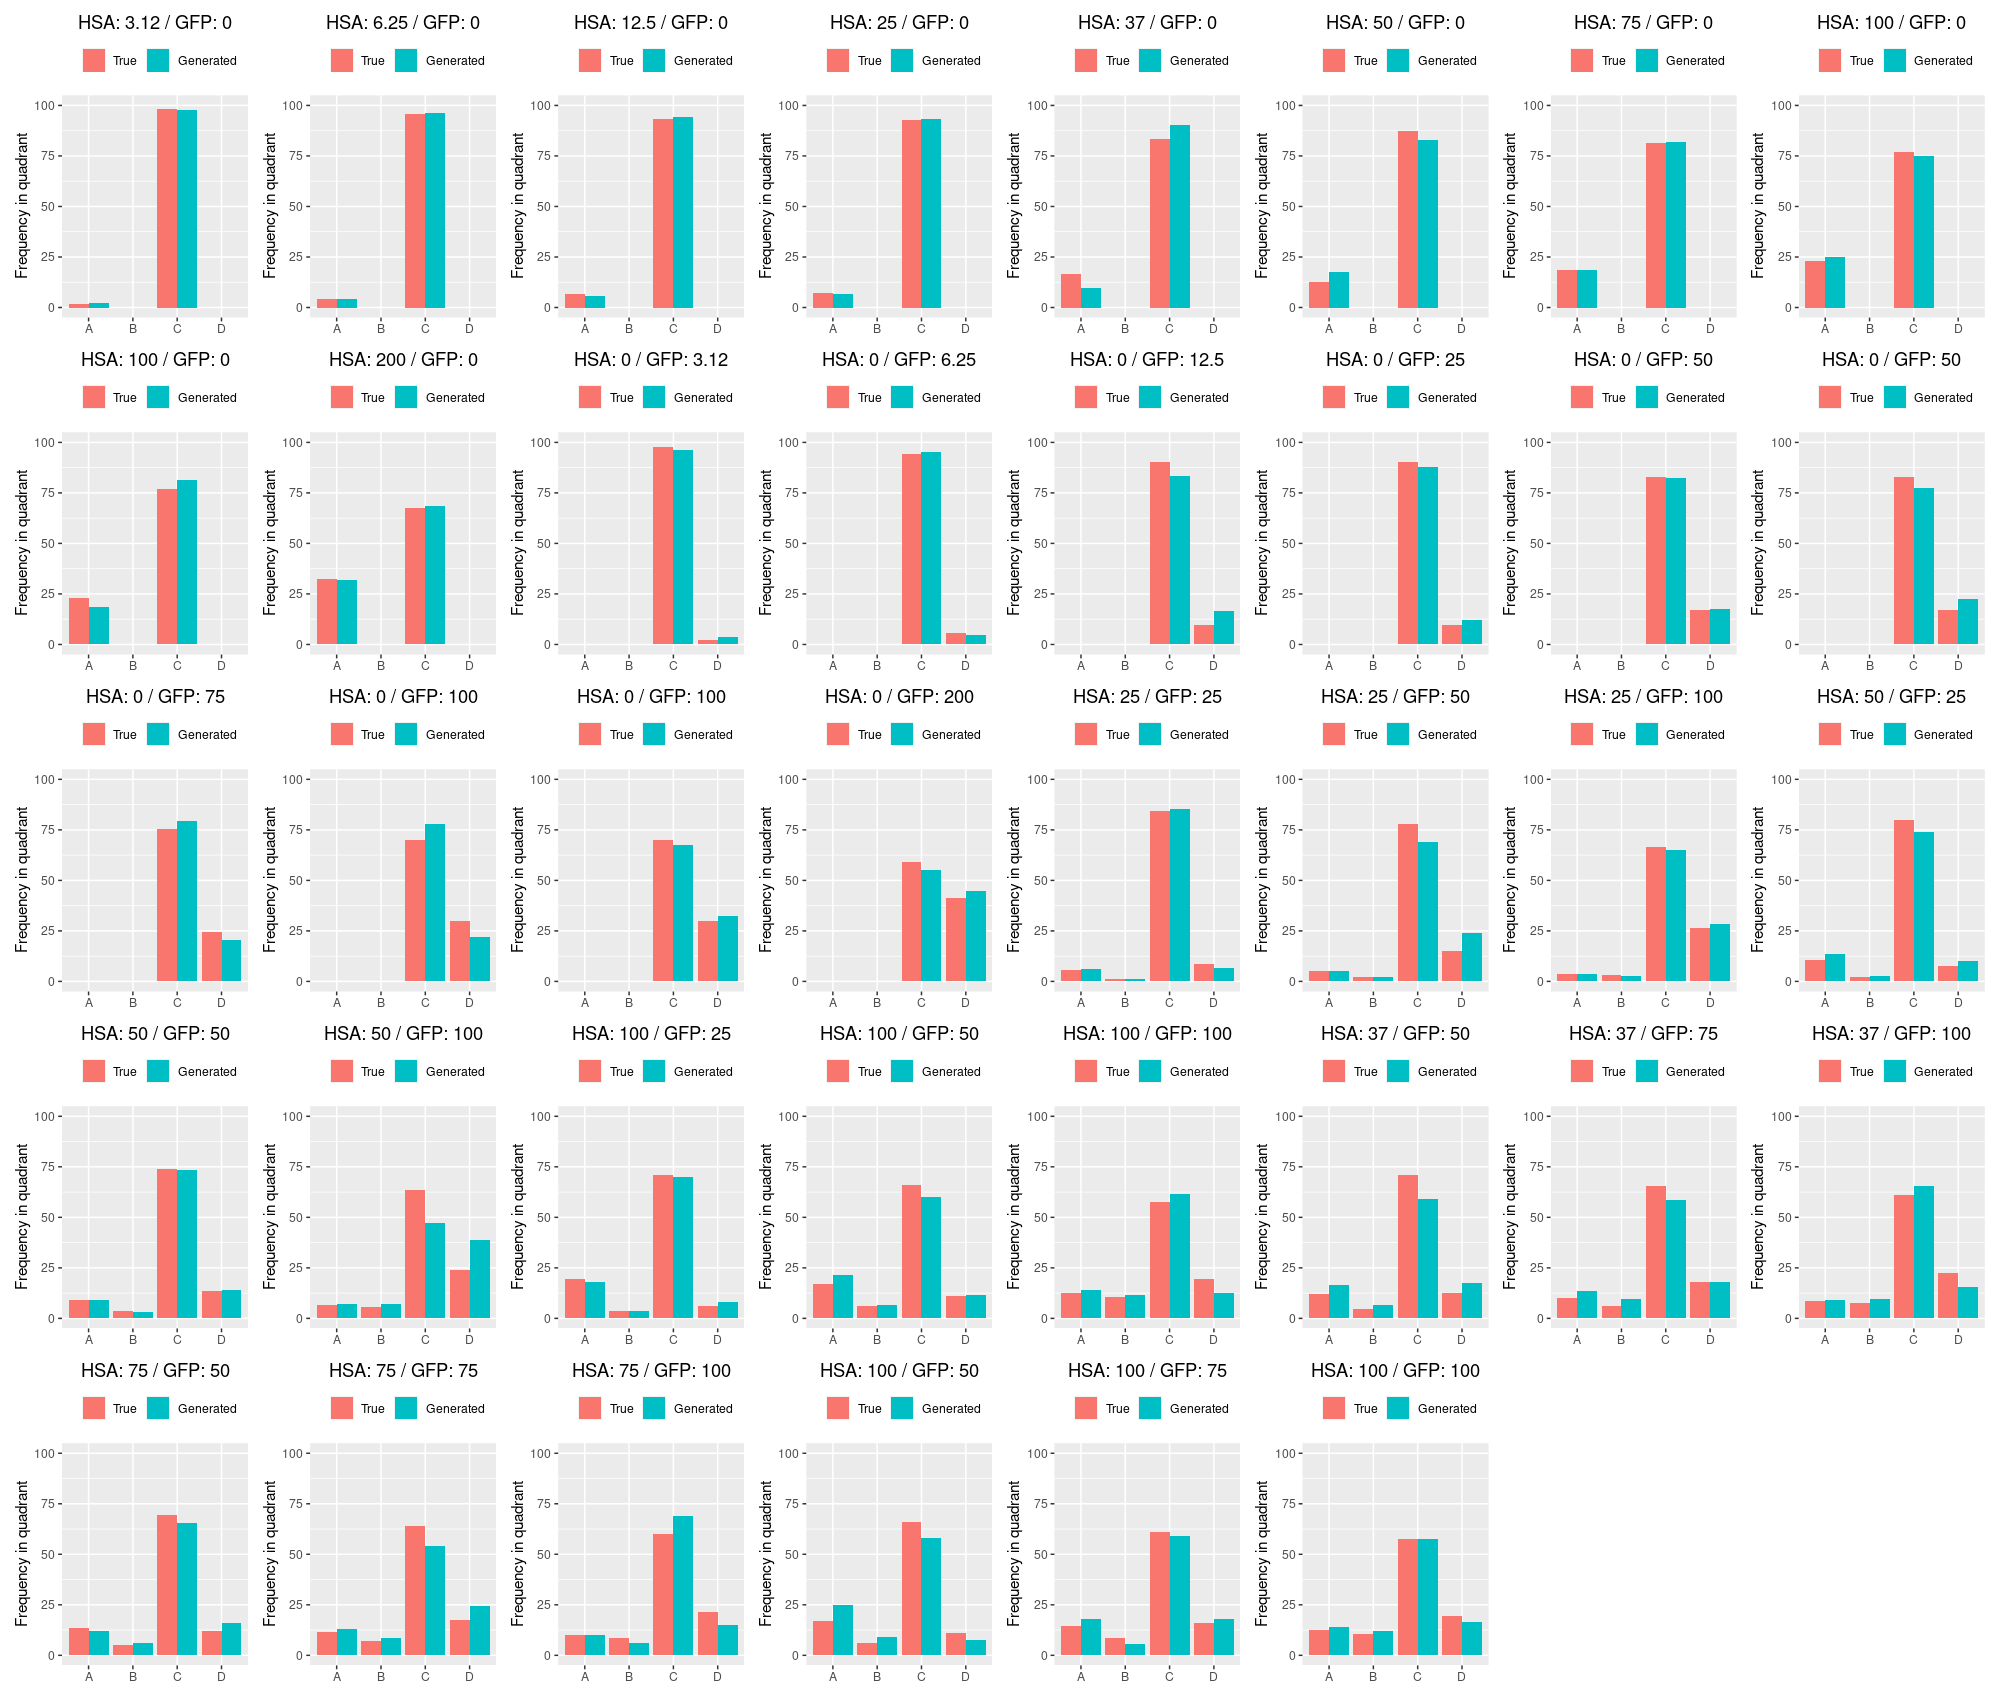

In [43]:
## データのプロット

plt <- list()

for (i in 1:nrow(data_true)) {
    data_temp <- rbind(data.frame(x = LETTERS[1:4], y = data_true[i, ], label = "True"),
                       data.frame(x = LETTERS[1:4], y = data_gen[i, ], label = "Generated"))
    data_temp$label <- factor(data_temp$label, levels = c("True", "Generated"))
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, y = y, fill = label)) +
        geom_bar(stat = "identity", position = "dodge") +
        scale_y_continuous(limits = c(0, 100)) +
        ylab("Frequency in quadrant") +
        labs(title = paste("HSA:", dose_exp$hsa[i], "/ GFP:", dose_exp$gfp[i])) +
        theme(legend.position = 'top',
              legend.title = element_blank(),
              axis.title.x = element_blank(),
              plot.title = element_text(hjust = 0.5))
}

options(repr.plot.width = 20, repr.plot.height = 17, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(ncol = 8)

In [47]:
model_stan_coinfection <- "
functions {
  
  real scale_par(int effective_virus, array[] real scales) {
    if (effective_virus == 1) {
        return 1.0;
    } else if (effective_virus > 1 && effective_virus < 10) {
        return scales[effective_virus + 2];
    }  else if (effective_virus == 0) {
        return 0.0;
    } else {
        return 1000000.0;
    }
  }
  array[] real model_coinfection(int c_hsa, int c_gfp, array[] real parms, int expt_type) {
    real p = parms[1];
    real beta_vhsa_q = parms[2];
    real beta_vgfp_q = parms[3];
    
    real j_scale_hsa = scale_par(c_hsa, parms);
    real j_scale_gfp = scale_par(c_gfp, parms);
    
    real f_a_co = 0.0; real f_b_co = 0.0; real f_c_co = 100.0; real f_d_co = 0.0;
    
    real f_hsa = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa), p);
    real f_gfp = 1.0/pow((1.0 + beta_vgfp_q*j_scale_gfp), p);
    real f_hsagfp = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp), p);
    
    if (c_hsa > 0 && c_gfp > 0) {
        f_a_co = f_gfp - f_hsagfp;
        f_b_co = 1.0 - f_gfp - f_hsa + f_hsagfp;
        f_c_co = f_hsagfp;
        f_d_co = f_hsa - f_hsagfp;
    } else if (c_hsa > 0) {
        f_a_co = 1.0 - f_hsa;
        f_b_co = 0.0;
        f_c_co = f_hsa;
        f_d_co = 0.0;
    } else if (c_gfp > 0) {
        f_a_co = 0.0;
        f_b_co = 0.0;
        f_c_co = f_gfp;
        f_d_co = 1.0 - f_gfp;
    } else {
    
    }
    
    if (expt_type == 1) {
      return {100.0*f_a_co, 100.0*f_c_co};
    } else if (expt_type == 2) {
      return {100.0*f_c_co, 100.0*f_d_co};
    } else {
      return {100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co};
    }
    
  }
  
  
}
data {
  int<lower=0> num_expt_HSA_single;         // number of experiments
  int<lower=0> num_expt_GFP_single;         // number of experiments
  int<lower=0> num_expt_co;         // number of experiments
  int<lower=0> num_quad_HSA_single;      // number of quadorants
  int<lower=0> num_quad_GFP_single;      // number of quadorants
  int<lower=0> num_quad_co;      // number of quadorants
  array[num_expt_HSA_single, num_quad_HSA_single] real freqs_HSA_single;   // frequency
  array[num_expt_GFP_single, num_quad_GFP_single] real freqs_GFP_single;   // frequency
  array[num_expt_co, num_quad_co] real freqs_co;   // frequency
  array[num_expt_HSA_single, 2] int conc_HSA_single;  //effective virus titier, HSA, GFP
  array[num_expt_GFP_single, 2] int conc_GFP_single;  //effective virus titier, HSA, GFP
  array[num_expt_co, 2] int conc_co;  //effective virus titier, HSA, GFP
}
parameters {
  // model parameters
  real<lower=log(0.01), upper=log(100.0)> p;
  real<lower=log(0.0001), upper=log(1.0)> beta_vhsa_q;
  real<lower=log(0.0001), upper=log(1.0)> beta_vgfp_q;
  real<lower=log(0.01), upper=log(100.0)> j625;
  real<lower=log(0.01), upper=log(100.0)> j125;
  real<lower=log(0.01), upper=log(100.0)> j25;
  real<lower=log(0.01), upper=log(100.0)> j37;
  real<lower=log(0.01), upper=log(100.0)> j50;
  real<lower=log(0.01), upper=log(100.0)> j75;
  real<lower=log(0.01), upper=log(100.0)> j100;
  real<lower=log(0.01), upper=log(100.0)> j200;
  
  // standard deviation of error model
  real<lower=0, upper=1000.0> sigma;
}
transformed parameters{
  array[num_expt_HSA_single, num_quad_HSA_single] real y_HSA_single;
  array[num_expt_GFP_single, num_quad_GFP_single] real y_GFP_single;
  array[num_expt_co, num_quad_co] real y_co;
  {
    array[11] real parms;
    parms[1] = exp(p); parms[2] = exp(beta_vhsa_q); parms[3] = exp(beta_vgfp_q);
    parms[4] = exp(j625); parms[5] = exp(j125); parms[6] = exp(j25); parms[7] = exp(j37);
    parms[8] = exp(j50); parms[9] = exp(j75); parms[10] = exp(j100); parms[11] = exp(j200);
    
    // HSA single
    for (i in 1:num_expt_HSA_single) {
      y_HSA_single[i,] = model_coinfection(conc_HSA_single[i, 1], conc_HSA_single[i, 2], parms, 1);
    }
    // GFP single
    for (i in 1:num_expt_GFP_single) {
      y_GFP_single[i,] = model_coinfection(conc_GFP_single[i, 1], conc_GFP_single[i, 2], parms, 2);
    }
    // coinfection
    for (i in 1:num_expt_co) {
      y_co[i,] = model_coinfection(conc_co[i, 1], conc_co[i, 2], parms, 3);
    }
    
  }
}
model {
  // priors
  p ~ uniform(log(0.01), log(100.0)); //1.176
  beta_vhsa_q ~ uniform(log(0.0001), log(1.0)); //1.484*np.power(10.0, -2.0)
  beta_vgfp_q ~ uniform(log(0.0001), log(1.0)); //2.115*np.power(10.0, -2.0)
  j625 ~ uniform(log(0.01), log(100.0)); //2.417
  j125 ~ uniform(log(0.01), log(100.0)); //4.231
  j25 ~ uniform(log(0.01), log(100.0)); //4.352
  j37 ~ uniform(log(0.01), log(100.0)); //11.09
  j50 ~ uniform(log(0.01), log(100.0)); //8.115
  j75 ~ uniform(log(0.01), log(100.0)); //12.79
  j100 ~ uniform(log(0.01), log(100.0)); //16.75
  j200 ~ uniform(log(0.01), log(100.0)); //26.87
  
  // HSA single
  for (i in 1:num_expt_HSA_single) {
    for (j in 1:num_quad_HSA_single) {
      freqs_HSA_single[i, j] ~ lognormal(log(y_HSA_single[i, j]), sigma);
    }
  }
  // GFP signle
  for (i in 1:num_expt_GFP_single) {
    for (j in 1:num_quad_GFP_single) {
      freqs_GFP_single[i, j] ~ lognormal(log(y_GFP_single[i, j]), sigma);
    }
  }
  // coinfection
  for (i in 1:num_expt_co) {
    for (j in 1:num_quad_co) {
      freqs_co[i, j] ~ lognormal(log(y_co[i, j]), sigma);
    }
  }
  sigma ~ cauchy(0,5);
}
"

In [56]:
freqs_HSA_single <- data_gen[1:10, c(1, 3)]
freqs_GFP_single <- data_gen[11:20, c(3, 4)]
freqs_co <- data_gen[21:38, ]
## 0: 0, 1: 3.12, 2: 6.25, 3: 12.5, 4: 25, 5: 37, 6: 50, 7: 75, 8: 100, 9: 200
d_hsa_single <- c(1, 2, 3, 4, 5, 6, 7, 8, 8, 9)
d_gfp_single <- c(1, 2, 3, 4, 6, 6, 7, 8, 8, 9)
d_hsa_co1 <- c(4, 6, 8)
d_hsa_co2 <- c(5, 7, 8)
d_gfp_co1 <- c(4, 6, 8)
d_gfp_co2 <- c(6, 7, 8)

conc_HSA_single <- matrix(c(d_hsa_single, rep(0, length(d_hsa_single))), ncol = 2)
conc_GFP_single <- matrix(c(rep(0, length(d_gfp_single)), d_gfp_single), ncol = 2)
conc_co <- matrix(c(rep(d_hsa_co1, each = length(d_gfp_co1)),
                    rep(d_hsa_co2, each = length(d_gfp_co2)),
                    rep(d_gfp_co1, length(d_hsa_co1)),
                    rep(d_gfp_co2, length(d_hsa_co2))), ncol = 2)

data_stan <- list(num_expt_HSA_single =  10,
                  num_expt_GFP_single = 10,
                  num_expt_co = 18,
                  num_quad_HSA_single = 2,
                  num_quad_GFP_single = 2,
                  num_quad_co = 4,
                  freqs_HSA_single = freqs_HSA_single,
                  freqs_GFP_single = freqs_GFP_single,
                  freqs_co = freqs_co,
                  conc_HSA_single = conc_HSA_single,
                  conc_GFP_single = conc_GFP_single,
                  conc_co = conc_co)

In [60]:
fit <- stan(model_code = model_stan_coinfection, data = data_stan, seed = 1,
            chains = 4, iter = 10000, warmup = 1000,
            cores = getOption("mc.cores", 4L))

In [61]:
df_fit <- as.data.frame(posterior)

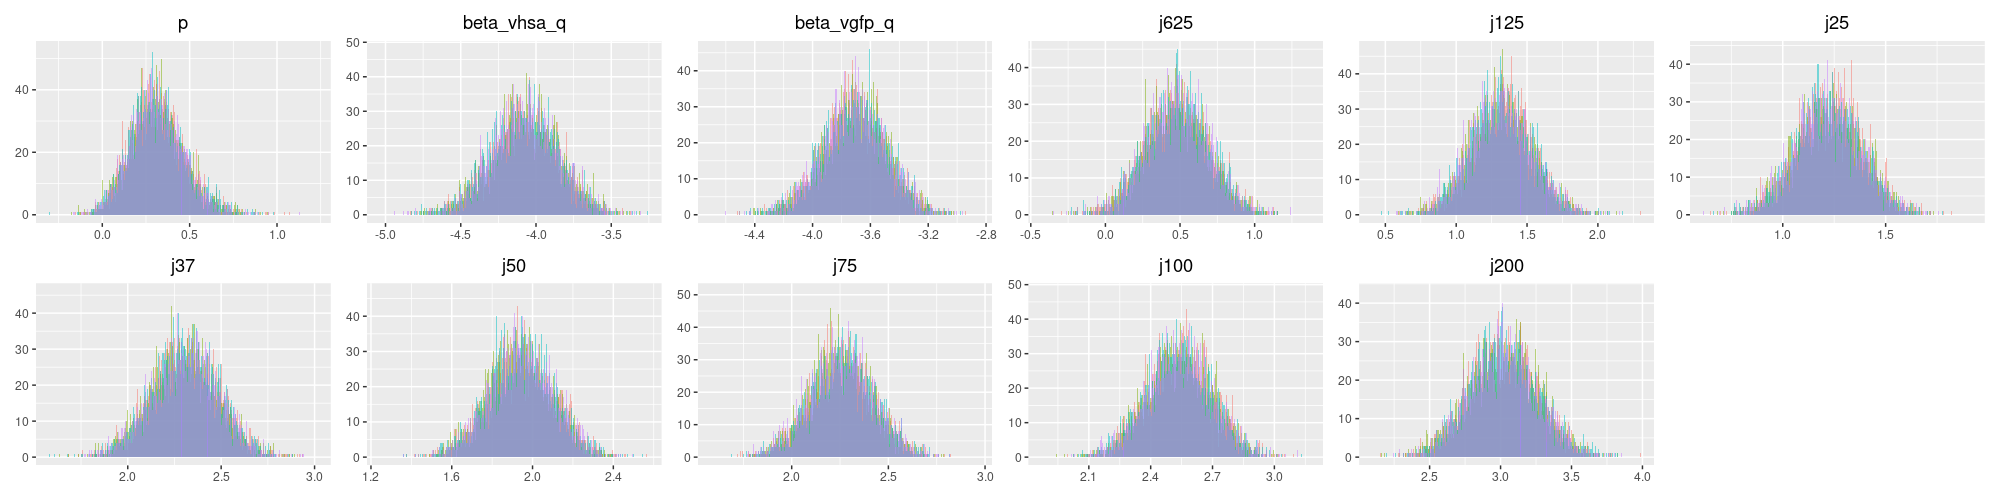

In [74]:
plt <- list()

for (i in 1:11) {
    data_temp <- data.frame(x = df_fit[, i], label = rep(letters[1:4], each = 9000))
    
    plt[[i]] <- ggplot(data = data_temp, aes(x = x, fill = label)) +
        geom_histogram(position = "identity", bins = 1000, alpha = 0.5) +
        labs(title = colnames(df_fit)[i]) +
        theme(plot.title = element_text(hjust = 0.5),
              legend.position = 'none',
              axis.title = element_blank())
}

options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
wrap_plots(plt) + plot_layout(ncol = 6)

[1] "p"                  "beta_vhsa_q"        "beta_vgfp_q"       
  [4] "j625"               "j125"               "j25"               
  [7] "j37"                "j50"                "j75"               
 [10] "j100"               "j200"               "sigma"             
 [13] "y_HSA_single[1,1]"  "y_HSA_single[2,1]"  "y_HSA_single[3,1]" 
 [16] "y_HSA_single[4,1]"  "y_HSA_single[5,1]"  "y_HSA_single[6,1]" 
 [19] "y_HSA_single[7,1]"  "y_HSA_single[8,1]"  "y_HSA_single[9,1]" 
 [22] "y_HSA_single[10,1]" "y_HSA_single[1,2]"  "y_HSA_single[2,2]" 
 [25] "y_HSA_single[3,2]"  "y_HSA_single[4,2]"  "y_HSA_single[5,2]" 
 [28] "y_HSA_single[6,2]"  "y_HSA_single[7,2]"  "y_HSA_single[8,2]" 
 [31] "y_HSA_single[9,2]"  "y_HSA_single[10,2]" "y_GFP_single[1,1]" 
 [34] "y_GFP_single[2,1]"  "y_GFP_single[3,1]"  "y_GFP_single[4,1]" 
 [37] "y_GFP_single[5,1]"  "y_GFP_single[6,1]"  "y_GFP_single[7,1]" 
 [40] "y_GFP_single[8,1]"  "y_GFP_single[9,1]"  "y_GFP_single[10,1]"
 [43] "y_GFP_single[1,2]"  "y_GFP_single[2,2]"  "y_GFP_single[3,2]" 
 [46] "y_GFP_single[4,2]"  "y_GFP_single[5,2]"  "y_GFP_single[6,2]" 
 [49] "y_GFP_single[7,2]"  "y_GFP_single[8,2]"  "y_GFP_single[9,2]" 
 [52] "y_GFP_single[10,2]" "y_co[1,1]"          "y_co[2,1]"         
 [55] "y_co[3,1]"          "y_co[4,1]"          "y_co[5,1]"         
 [58] "y_co[6,1]"          "y_co[7,1]"          "y_co[8,1]"         
 [61] "y_co[9,1]"          "y_co[10,1]"         "y_co[11,1]"        
 [64] "y_co[12,1]"         "y_co[13,1]"         "y_co[14,1]"        
 [67] "y_co[15,1]"         "y_co[16,1]"         "y_co[17,1]"        
 [70] "y_co[18,1]"         "y_co[1,2]"          "y_co[2,2]"         
 [73] "y_co[3,2]"          "y_co[4,2]"          "y_co[5,2]"         
 [76] "y_co[6,2]"          "y_co[7,2]"          "y_co[8,2]"         
 [79] "y_co[9,2]"          "y_co[10,2]"         "y_co[11,2]"        
 [82] "y_co[12,2]"         "y_co[13,2]"         "y_co[14,2]"        
 [85] "y_co[15,2]"         "y_co[16,2]"         "y_co[17,2]"        
 [88] "y_co[18,2]"         "y_co[1,3]"          "y_co[2,3]"         
 [91] "y_co[3,3]"          "y_co[4,3]"          "y_co[5,3]"         
 [94] "y_co[6,3]"          "y_co[7,3]"          "y_co[8,3]"         
 [97] "y_co[9,3]"          "y_co[10,3]"         "y_co[11,3]"        
[100] "y_co[12,3]"         "y_co[13,3]"         "y_co[14,3]"        
[103] "y_co[15,3]"         "y_co[16,3]"         "y_co[17,3]"        
[106] "y_co[18,3]"         "y_co[1,4]"          "y_co[2,4]"         
[109] "y_co[3,4]"          "y_co[4,4]"          "y_co[5,4]"         
[112] "y_co[6,4]"          "y_co[7,4]"          "y_co[8,4]"         
[115] "y_co[9,4]"          "y_co[10,4]"         "y_co[11,4]"        
[118] "y_co[12,4]"         "y_co[13,4]"         "y_co[14,4]"        
[121] "y_co[15,4]"         "y_co[16,4]"         "y_co[17,4]"        
[124] "y_co[18,4]"         "lp__"

In [ ]:
colnames(df_fit)